In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
import io
import os
from datetime import datetime


/opt/homebrew/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
# read the ONI data file as a list of strings
with open('oni.data', 'r') as file:
    lines = file.readlines()

app = []

# process the list of strings
for i, line in enumerate(lines[1:]):
    sp = line.split()
    if sp[0] == '2023':
        break
    app.append(' '.join(line.split()))

# join the list of strings into a single string and read it as a CSV
data = '\n'.join(app)

oni_values = pd.read_csv(io.StringIO(data), sep='\s+', header=None)

# use melt to unpivot the columns
oni_values = oni_values.melt(id_vars=[0], var_name='month', value_name='ONI')

# create a datetime column from the year and month columns
oni_values['date'] = pd.to_datetime(oni_values[0].astype(str) + '-' + oni_values['month'].astype(str), format='%Y-%m')

# drop the original year and month columns
oni_values.drop([0, 'month'], axis=1, inplace=True)

# set the date column as the index
oni_values.set_index('date', inplace=True)

# sort the index
oni_values.sort_index(inplace=True)

display(oni_values)


,ONI
date,
1950-01-01,-1.53
1950-02-01,-0.68
1950-03-01,-0.45
1950-04-01,-1.18
1950-05-01,-1.07
...,...
2022-08-01,-0.91
2022-09-01,-1.01
2022-10-01,-0.99


In [4]:
# This function converts a coordinate string into a float value, depending on its direction
def convert_coordinates(coord):
    if 'N' in coord:
        return float(coord[:-1])
    elif 'S' in coord:
        return -float(coord[:-1])
    elif 'E' in coord:
        return float(coord[:-1])
    elif 'W' in coord:
        return -float(coord[:-1])


# This function reads SST data from ASCII files in a given directory and returns a pandas DataFrame
def read_sst_ascii_files(directory):
    data = []
    for file in os.listdir(directory):
        with open(os.path.join(directory, file), 'r') as f:
            # Read all lines from the file and split the first line into location information
            lines = f.readlines()
            location = lines[0].split()
            lat, lon = convert_coordinates(location[1]), convert_coordinates(location[2])

            # Loop through all lines in the file and extract the SST data
            for line in lines:
                if line.strip().split()[0].isdigit():
                    fields = line.strip().split()
                    date_time = datetime.strptime(fields[0] + fields[1], '%Y%m%d%H%M') # Parse the date and time
                    sst = float(fields[2]) # Convert the SST value to a float
                    if sst == -9.99:
                        sst = None
                    data.append([''.join(location[1:3]), lat, lon, date_time, sst]) # Append the data to the list

    # Convert the list of data to a pandas DataFrame
    df = pd.DataFrame(data, columns=['Buoy ID', 'Buoy Latitude', 'Buoy Longitude', 'Datetime of Measurement', 'SST'])
    return df


# Set the directory where the SST data files are located
directory = 'sst/'

# Read the SST data from the ASCII files and display the resulting pandas DataFrame
sst_data = read_sst_ascii_files(directory)
display(sst_data)


,Buoy ID,Buoy Latitude,Buoy Longitude,Datetime of Measurement,SST
0,0.0N110.5W,0.0,-110.5,1979-01-24 12:00:00,24.10
1,0.0N110.5W,0.0,-110.5,1979-01-29 12:00:00,24.53
2,0.0N110.5W,0.0,-110.5,1979-02-03 12:00:00,26.00
3,0.0N110.5W,0.0,-110.5,1979-02-08 12:00:00,26.31
4,0.0N110.5W,0.0,-110.5,1979-02-13 12:00:00,25.11
...,...,...,...,...,...
123416,2N140W,2.0,-140.0,2022-03-30 12:00:00,26.52
123417,2N140W,2.0,-140.0,2022-04-04 12:00:00,26.63
123418,2N140W,2.0,-140.0,2022-04-09 12:00:00,26.81
123419,2N140W,2.0,-140.0,2022-04-14 12:00:00,26.76


In [5]:
# This function reads wind data from ASCII files in a given directory and returns a pandas DataFrame
def read_wind_ascii_files(directory):
    data = []
    for file in os.listdir(directory):
        with open(os.path.join(directory, file), 'r') as f:
            # Read all lines from the file and split the first line into location information
            lines = f.readlines()
            location = lines[0].split()
            lat, lon = convert_coordinates(location[1]), convert_coordinates(location[2])

            # Loop through all lines in the file and extract the wind data
            for line in lines:
                if line.strip().split()[0].isdigit():
                    fields = line.strip().split()
                    date_time = datetime.strptime(fields[0] + fields[1], '%Y%m%d%H%M') # Parse the date and time
                    # Convert the wind values to floats, replacing -99.9 with None
                    wind_values = [float(val) if float(val) != -99.9 else None for val in fields[2:6]]
                    # Check that we have exactly 4 wind values, otherwise exit with an error
                    if len(wind_values) != 4:
                        print(wind_values)
                        exit()
                    data.append([''.join(location[1:3]), lat, lon, date_time] + wind_values) # Append the data to the list

    # Convert the list of data to a pandas DataFrame
    df = pd.DataFrame(data, columns=['Buoy ID', 'Buoy Latitude', 'Buoy Longitude', 'Datetime of Measurement', 'Uwind', 'Vwind', 'Windspeed', 'Wind Direction'])
    return df


# Read wind data from the 'wind/' directory and display the resulting pandas DataFrame
wind_data = read_wind_ascii_files('wind/')
display(wind_data)

# Merge the SST and wind data into a single DataFrame based on matching location and time information
climate_conditions = pd.merge(sst_data, wind_data, on=['Buoy ID', 'Buoy Latitude', 'Buoy Longitude', 'Datetime of Measurement'], how='outer')
display(climate_conditions)


,Buoy ID,Buoy Latitude,Buoy Longitude,Datetime of Measurement,Uwind,Vwind,Windspeed,Wind Direction
0,8N95W,8.0,-95.0,1994-08-12 12:00:00,4.1,3.6,5.8,49.2
1,8N95W,8.0,-95.0,1994-08-17 12:00:00,1.1,1.5,2.4,37.5
2,8N95W,8.0,-95.0,1994-08-22 12:00:00,4.3,4.0,5.9,46.9
3,8N95W,8.0,-95.0,1994-08-27 12:00:00,1.7,1.1,3.9,56.6
4,8N95W,8.0,-95.0,1994-09-01 12:00:00,2.0,2.6,3.5,38.0
...,...,...,...,...,...,...,...,...
114678,2N137E,2.0,137.0,2015-03-30 12:00:00,2.6,-1.5,3.1,120.0
114679,2N137E,2.0,137.0,2015-04-04 12:00:00,0.8,-2.2,3.3,161.4
114680,2N137E,2.0,137.0,2015-04-09 12:00:00,1.8,-2.6,3.3,145.4
114681,2N137E,2.0,137.0,2015-04-14 12:00:00,0.6,0.1,2.1,78.7


,Buoy ID,Buoy Latitude,Buoy Longitude,Datetime of Measurement,SST,Uwind,Vwind,Windspeed,Wind Direction
0,0.0N110.5W,0.0,-110.5,1979-01-24 12:00:00,24.10,-2.6,3.2,4.3,320.4
1,0.0N110.5W,0.0,-110.5,1979-01-29 12:00:00,24.53,-3.3,3.0,4.6,312.3
2,0.0N110.5W,0.0,-110.5,1979-02-03 12:00:00,26.00,-1.0,2.4,3.0,336.8
3,0.0N110.5W,0.0,-110.5,1979-02-08 12:00:00,26.31,-2.2,4.2,5.3,332.2
4,0.0N110.5W,0.0,-110.5,1979-02-13 12:00:00,25.11,-3.0,2.7,4.2,312.0
...,...,...,...,...,...,...,...,...,...
134614,2N180W,2.0,-180.0,2023-03-30 12:00:00,NaN,-5.3,0.0,5.7,269.9
134615,2N180W,2.0,-180.0,2023-04-04 12:00:00,NaN,-7.3,-1.3,7.4,259.6
134616,2N180W,2.0,-180.0,2023-04-09 12:00:00,NaN,-5.7,-0.4,5.9,265.8
134617,2N180W,2.0,-180.0,2023-04-14 12:00:00,NaN,-3.9,0.0,4.2,270.7


In [6]:
# Define a function to create features from climate data for each buoy ID and month
def create_features(climate_df, period=pd.DateOffset(months=1)):
    # Add a new column to the climate data with the month of each measurement
    climate_df['Month'] = climate_df['Datetime of Measurement'].dt.to_period('M')
    # Group the data by buoy ID and month and calculate the mean for each group
    features = climate_df.groupby(['Buoy ID', 'Month']).mean().reset_index()
    # Add a new column to the features with the next month, based on the given period offset
    features['Month'] = features['Month'].apply(lambda x: x.to_timestamp()) + period
    return features


# Define a function to merge ONI data and features data based on the month
def merge_oni_and_features(oni_df, features):
    merged_df = pd.merge(features, oni_df, left_on='Month', right_on=oni_df.index, how='inner')
    return merged_df


# Define a function to train a machine learning model on the merged data up to a given date
def train_model(merged_df, max_train_date):
    # Filter the merged data to include only rows up to the max train date
    merged_df = merged_df[merged_df['Month'] <= max_train_date]
    
    # Separate the input features and output variable
    X = merged_df.drop(columns=['ONI', 'Buoy ID', 'Month']).apply(pd.to_numeric, errors='coerce')
    y = merged_df['ONI']

    # Train a histogram-based gradient boosting regressor model on the filtered data
    model = HistGradientBoostingRegressor()
    model.fit(X, y)
    
    return model


# Define a function to predict the ONI value for a given date using a trained model and features
def predict_oni(model, features, date):
    # Filter the features to include only the rows for the given date and convert to numeric values
    features_to_predict = features.loc[features['Month'] == str(date)].drop(columns=['Buoy ID', 'Month']).apply(pd.to_numeric, errors='coerce')
    # Use the trained model to predict the ONI value for the given date
    predictions = model.predict(features_to_predict)
    # Calculate the mean prediction from the multiple predictions made by the model
    mean_prediction = np.mean(predictions)
    return mean_prediction


In [7]:
# Define a list of months in advance to predict the ONI value for
months_in_advance = [1, 2, 4, 6, 8, 12, 24]

# Initialize an empty list to store the results
results = []

# Set an option to display up to 1000 rows of data in pandas dataframes
pd.set_option('display.max_rows', 1000)

# Loop through each month from January 1990 to December 2022
start_date = datetime(1990, 1, 1).date()
end_date = datetime(2022, 12, 1).date()

while start_date <= end_date:
    date_to_predict = start_date

    # Make predictions for each month in advance specified
    predictions = []
    for m in months_in_advance:
        # Set the maximum date to train the model on based on the number of months in advance
        max_train_date = date_to_predict - pd.DateOffset(months=m)
        
        # Create features data for the climate conditions up to the maximum train date
        features = create_features(climate_conditions, period=pd.DateOffset(months=m))
        # Merge the ONI values and features data for the same months
        merged = merge_oni_and_features(oni_values, features)
        # Train a model on the merged data up to the maximum train date
        model = train_model(merged, max_train_date)
        # Make a prediction for the current month and number of months in advance
        prediction = predict_oni(model, features, date_to_predict)
        # Append the prediction to the list of predictions
        predictions.append(prediction)
        # Print the prediction for the current month and number of months in advance
        print(f"Predicted ONI values for {date_to_predict} {m} months in advance: {predictions[-1]}")

    # Get the actual ONI value for the current month
    actual_oni = oni_values.loc[pd.Timestamp(start_date), "ONI"]
    
    # Append the actual ONI value and list of predictions to the results list
    results.append([start_date, actual_oni] + predictions)

    # Move to the next month
    start_date = (start_date + pd.DateOffset(months=1)).date()

# Define the column names for the results dataframe
cols = ["Month/Year", "Actual ONI"] + ["Predicted " + str(m) + " months before" for m in months_in_advance]
# Create a dataframe from the results list with the specified column names
results_df = pd.DataFrame(results, columns=cols)

# Display the results dataframe
display(results_df)


Predicted ONI values for 1990-01-01 1 months in advance: -0.09251394356315379
Predicted ONI values for 1990-01-01 2 months in advance: -0.1878264532331933
Predicted ONI values for 1990-01-01 4 months in advance: -0.24874268635558158
Predicted ONI values for 1990-01-01 6 months in advance: -0.35402930306424146
Predicted ONI values for 1990-01-01 8 months in advance: -0.7154677316506065
Predicted ONI values for 1990-01-01 12 months in advance: -1.761119771978321
Predicted ONI values for 1990-01-01 24 months in advance: 1.0324113270177515
Predicted ONI values for 1990-02-01 1 months in advance: 0.06518603326146918
Predicted ONI values for 1990-02-01 2 months in advance: -0.10285441335162006
Predicted ONI values for 1990-02-01 4 months in advance: -0.23396401582654677
Predicted ONI values for 1990-02-01 6 months in advance: -0.30142888936523715
Predicted ONI values for 1990-02-01 8 months in advance: -0.5126052872108523
Predicted ONI values for 1990-02-01 12 months in advance: -1.502793004

,Month/Year,Actual ONI,Predicted 1 months before,Predicted 2 months before,Predicted 4 months before,Predicted 6 months before,Predicted 8 months before,Predicted 12 months before,Predicted 24 months before
0,1990-01-01,0.14,-0.092514,-0.187826,-0.248743,-0.354029,-0.715468,-1.761120,1.032411
1,1990-02-01,0.21,0.065186,-0.102854,-0.233964,-0.301429,-0.512605,-1.502793,0.786247
2,1990-03-01,0.28,0.205859,0.048540,-0.190881,-0.261439,-0.371425,-1.211511,0.425021
3,1990-04-01,0.29,0.255128,0.179530,-0.099730,-0.233112,-0.292455,-0.986489,0.115966
4,1990-05-01,0.29,0.289887,0.270790,0.042410,-0.182684,-0.257472,-0.705164,-0.111641
5,1990-06-01,0.31,0.290964,0.286062,0.168072,-0.104868,-0.234754,-0.486201,-0.650539
6,1990-07-01,0.33,0.308689,0.290041,0.245600,0.044198,-0.197422,-0.340063,-1.156745
7,1990-08-01,0.38,0.329367,0.299032,0.283159,0.174619,-0.110097,-0.289700,-1.189780
8,1990-09-01,0.39,0.379525,0.327003,0.288658,0.246133,0.061969,-0.257902,-1.204777
9,1990-10-01,0.35,0.383790,0.376150,0.299545,0.284100,0.175735,-0.232575,-1.240253


In [22]:
# Save the original DataFrame as a CSV file
results_df.to_csv('oni_predictions.csv', index=False)

# Calculate the absolute difference/error for each "Predicted x months before" column
columns_to_calculate = [f'Predicted {m} months before' for m in months_in_advance]

accuracy_df = results_df.copy()
for column in columns_to_calculate:
    accuracy_df[column] = abs((results_df[column] - results_df["Actual ONI"]))

# Display the new DataFrame
display(accuracy_df)


,Month/Year,Actual ONI,Predicted 1 months before,Predicted 2 months before,Predicted 4 months before,Predicted 6 months before,Predicted 8 months before,Predicted 12 months before,Predicted 24 months before
0,1990-01-01,0.14,0.232514,0.327826,0.388743,0.494029,0.855468,1.901120,0.892411
1,1990-02-01,0.21,0.144814,0.312854,0.443964,0.511429,0.722605,1.712793,0.576247
2,1990-03-01,0.28,0.074141,0.231460,0.470881,0.541439,0.651425,1.491511,0.145021
3,1990-04-01,0.29,0.034872,0.110470,0.389730,0.523112,0.582455,1.276489,0.174034
4,1990-05-01,0.29,0.000113,0.019210,0.247590,0.472684,0.547472,0.995164,0.401641
5,1990-06-01,0.31,0.019036,0.023938,0.141928,0.414868,0.544754,0.796201,0.960539
6,1990-07-01,0.33,0.021311,0.039959,0.084400,0.285802,0.527422,0.670063,1.486745
7,1990-08-01,0.38,0.050633,0.080968,0.096841,0.205381,0.490097,0.669700,1.569780
8,1990-09-01,0.39,0.010475,0.062997,0.101342,0.143867,0.328031,0.647902,1.594777
9,1990-10-01,0.35,0.033790,0.026150,0.050455,0.065900,0.174265,0.582575,1.590253


In [23]:
# Calculate the mean of each "Predicted x months before" column in accuracy_df
mean_values = accuracy_df[columns_to_calculate].mean()
std_values = accuracy_df[columns_to_calculate].std()

# Create a new DataFrame with the mean values
average_df = pd.DataFrame({'Prediction Column': mean_values.index, 'Mean Absolute Error': mean_values.values, 'Standard Deviation': std_values.values})
display(average_df)


,Prediction Column,Mean Absolute Error,Standard Deviation
0,Predicted 1 months before,0.164228,0.125703
1,Predicted 2 months before,0.303498,0.235431
2,Predicted 4 months before,0.529899,0.429506
3,Predicted 6 months before,0.694096,0.586913
4,Predicted 8 months before,0.792512,0.710023
5,Predicted 12 months before,0.891701,0.787771
6,Predicted 24 months before,1.061751,0.810830


,Mean Absolute Error
Month,
1,0.959646
2,0.923332
3,0.868641
4,0.824293
5,0.774281
6,0.664329
7,0.499526
8,0.331968
9,0.340871


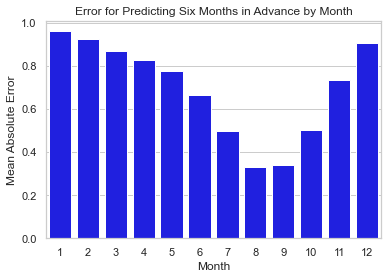

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

graphing_df = accuracy_df.copy()

# Step 1: Convert the "Month/Year" column to a datetime object
graphing_df['Month/Year'] = pd.to_datetime(graphing_df['Month/Year'])

# Step 2: Undo the 6-month shift
graphing_df['Month/Year'] = graphing_df['Month/Year'] - pd.DateOffset(months=6)

# Step 3: Group by month and calculate the average value for each month across all years
graphing_df['Month'] = graphing_df['Month/Year'].dt.month
monthly_average = pd.DataFrame(graphing_df.groupby('Month')['Predicted 6 months before'].mean())

monthly_average = monthly_average.rename(columns={'Predicted 6 months before': 'Mean Absolute Error'})

display(monthly_average)

# Convert the average_values_by_month into a DataFrame
average_values_df = monthly_average.reset_index()
average_values_df.columns = ['Month', 'Average Value']

# Set the style for the Seaborn plot
sns.set(style='whitegrid')

# Create a bar plot with months on the x-axis and average values on the y-axis
bar_plot = sns.barplot(x='Month', y='Average Value', data=average_values_df, color='blue')

# Set the title and labels for the plot
bar_plot.set(title='Error for Predicting Six Months in Advance by Month', xlabel='Month', ylabel='Mean Absolute Error')

# Display the plot
plt.show()
